CycleGAN Faces to Lymph Node Sections 

In [32]:
import tensorflow as tf
import tensorflow_datasets as ds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np


AUTOTUNE = tf.data.AUTOTUNE



In [138]:
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
BUFFER_SIZE = 1000
BATCH_SIZE = 1

In [111]:
def normalize(image):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image
def denormalize(image):
    image = tf.cast(image, tf.float32)
    image = (image * 0.5 + 0.5) * 255
    image = tf.cast(image, tf.int32)
    return image
def random_jitter(image):
    # resizing to 256 x 256 x 3
    image = tf.image.resize(image, [IMAGE_WIDTH,IMAGE_HEIGHT])

    # random mirroring
    image = tf.image.random_flip_left_right(image)

    return image

def preprocess_image_train(image):
    image = random_jitter(image)
    image = normalize(image)
    image = tf.image.resize(image, [IMAGE_WIDTH,IMAGE_HEIGHT])
    return image

def preprocess_image_test(image):
    image = normalize(image)
    image = tf.image.resize(image, [IMAGE_WIDTH,IMAGE_HEIGHT])
    return image

def preprocess_labelfirst_train(dataset):
    return dataset.map(lambda x, y: y).map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

def preprocess_labelfirst_test(dataset):
    return dataset.map(lambda x, y: y).map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    
def preprocess_labellast_train(dataset):
    return dataset.map(lambda x, y: x).map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

def preprocess_labellast_test(dataset):
    return dataset.map(lambda x, y: x).map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)



In [170]:
f_train, _ = ds.load("lfw", split='train[:85%]', with_info=True, as_supervised=True, shuffle_files=True)
f_test, _ = ds.load("lfw", split='train[85%:]', with_info=True, as_supervised=True, shuffle_files=True)


In [171]:
camelyon, _ = ds.load("patch_camelyon", split=['test[:10%]', 'train[:10%]'], with_info=True, as_supervised=True, shuffle_files = True)


In [172]:
c_test = camelyon[0]
c_train = camelyon[1]


In [173]:
print(f_train)
print(c_train)

<PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(250, 250, 3), dtype=tf.uint8, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(96, 96, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [174]:
print("The number of train images used in the faces dataset is ", len(f_train))
print("The number of test images used in the faces dataset is ", len(f_test))
print("The number of train images in the patch_camelyon dataset is ", len(c_train))
print("The number of test images in the patch_camelyon dataset is ", len(c_test))


The number of train images used in the faces dataset is  11248
The number of test images used in the faces dataset is  1985
The number of train images in the patch_camelyon dataset is  26214
The number of test images in the patch_camelyon dataset is  3277


In [175]:
f_train = preprocess_labelfirst_train(f_train)

c_train = preprocess_labellast_train(c_train)

f_test = preprocess_labelfirst_test(f_test)

c_test = preprocess_labellast_test(c_test)



In [176]:
print(c_train)
print(f_train)

<BatchDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>
<BatchDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>


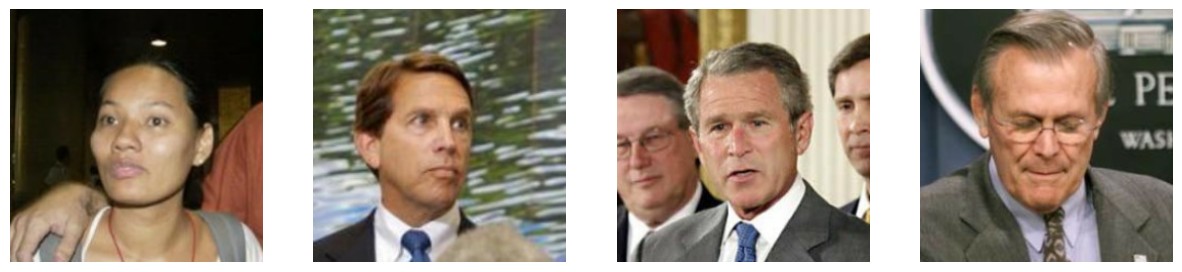

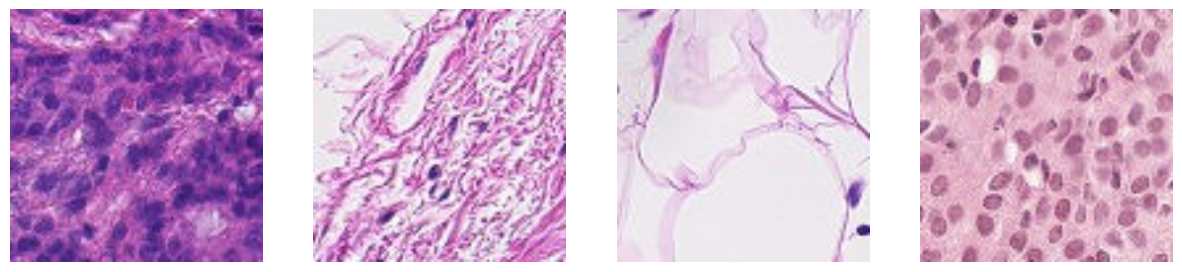

In [177]:
plt.figure(figsize=(15,15))
for i, img in enumerate(f_train.take(4)):
    plt.subplot(1,4,i+1)
    plt.imshow(img[0]*.5 +.5)
    plt.axis('off')
plt.show()

plt.figure(figsize=(15,15))
for i, img in enumerate(c_train.take(4)):
    plt.subplot(1,4,i+1)
    plt.imshow(img[0]*.5 +.5)
    plt.axis('off')
plt.show()

In [178]:
sample_face = next(iter(f_train))
sample_camelyon = next(iter(c_train))

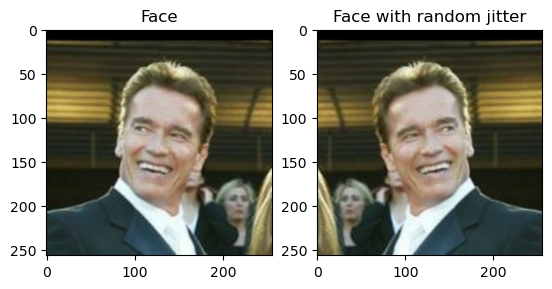

In [179]:
plt.subplot(121)
plt.title('Face')
plt.imshow(sample_face[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Face with random jitter')
plt.imshow(random_jitter(sample_face[0]) * 0.5 + 0.5)

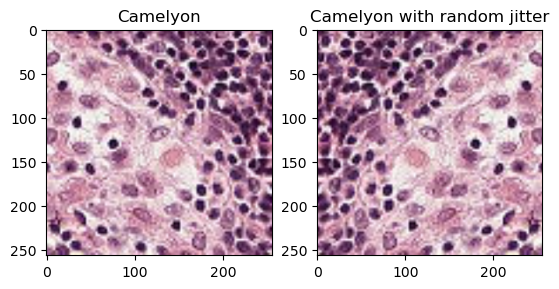

In [180]:
plt.subplot(121)
plt.title('Camelyon')
plt.imshow(sample_camelyon[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Camelyon with random jitter')
plt.imshow(random_jitter(sample_camelyon[0]) * 0.5 + 0.5)

In [181]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

In [182]:
print(generator_g.summary())

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 sequential_180 (Sequential)    (None, None, None,   3072        ['input_11[0][0]']               
                                64)                                                               
                                                                                                  
 sequential_181 (Sequential)    (None, None, None,   131328      ['sequential_180[0][0]']         
                                128)                                                       

(1, 256, 256, 3)
(1, 256, 256, 3)


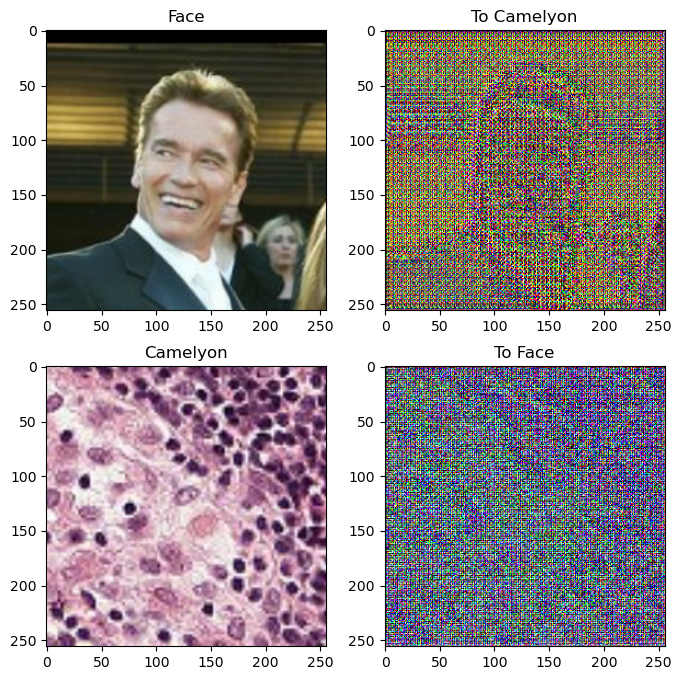

In [183]:
print(sample_face.shape)
print(sample_camelyon.shape)
to_cam = generator_g(sample_face)
to_face = generator_f(sample_camelyon)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_face, to_cam, sample_camelyon, to_face]
title = ['Face', 'To Camelyon', 'Camelyon', 'To Face']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

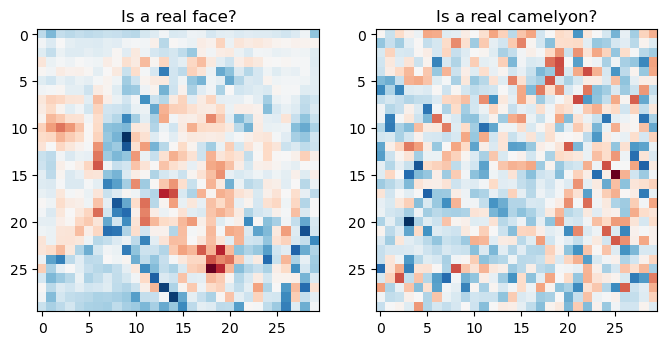

In [184]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real face?')
plt.imshow(discriminator_y(sample_face)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real camelyon?')
plt.imshow(discriminator_x(sample_camelyon)[0, ..., -1], cmap='RdBu_r')

plt.show()

In [185]:
LAMBDA = 10
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [186]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1

def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [187]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [188]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [189]:
EPOCHS = 10

In [191]:
def generate_images(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [192]:
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.

    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)

  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

26214
11248
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


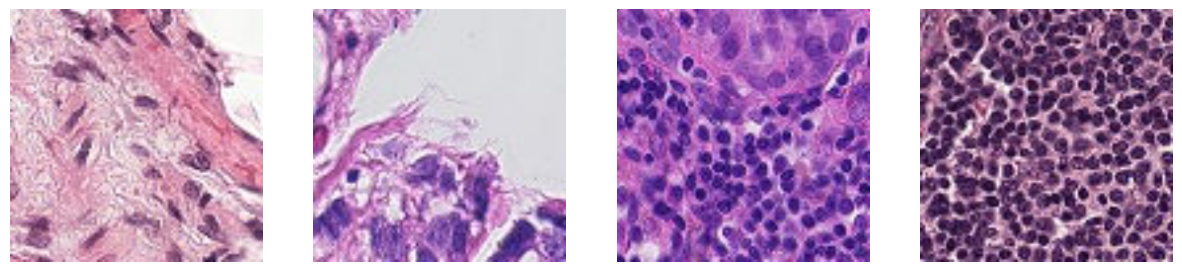

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


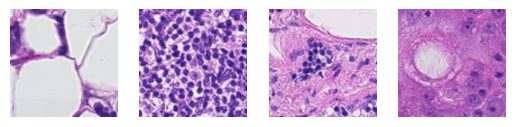

In [208]:
print(len(c_train))
print(len(f_train))
plt.figure(figsize=(15,15))
for i, img in enumerate(c_train.take(4)):
    print(img[0].shape)
    plt.subplot(1,4,i+1)
    plt.imshow(img[0]*.5 +.5)
    plt.axis('off')
plt.show()    
for i, img in enumerate(c_train.take(4)):
    print(img[0].shape)
    plt.subplot(1,4,i+1)
    plt.imshow(img[0]*.5 +.5)
    plt.axis('off')
plt.show()    

In [223]:

enum = f_train.take(1)
print(len(enum))
for ele in enum:
    print(ele)


1
tf.Tensor(
[[[[-0.19999999  0.13725495  0.20784318]
   [-0.19999999  0.13725495  0.20784318]
   [-0.20738357  0.12987137  0.2004596 ]
   ...
   [ 0.8592831   0.8671262   0.827451  ]
   [ 0.8666667   0.8745098   0.827451  ]
   [ 0.8666667   0.8745098   0.827451  ]]

  [[-0.19243258  0.14482236  0.21541059]
   [-0.19243258  0.14482236  0.21541059]
   [-0.20694017  0.13031471  0.20090294]
   ...
   [ 0.8592831   0.8671262   0.827451  ]
   [ 0.8666667   0.8745098   0.827451  ]
   [ 0.8666667   0.8745098   0.827451  ]]

  [[-0.19215685  0.14509809  0.20091915]
   [-0.19215685  0.14509809  0.20091915]
   [-0.20692402  0.13033092  0.18615198]
   ...
   [ 0.8588505   0.8666936   0.827451  ]
   [ 0.8592831   0.8671262   0.827451  ]
   [ 0.8592831   0.8671262   0.827451  ]]

  ...

  [[ 0.7420956   0.39745712  0.10818017]
   [ 0.74921954  0.40458107  0.12999558]
   [ 0.75686276  0.4048407   0.16075742]
   ...
   [-0.30088395 -0.5813986  -0.76917434]
   [-0.34213626 -0.59311664 -0.77350885]
   

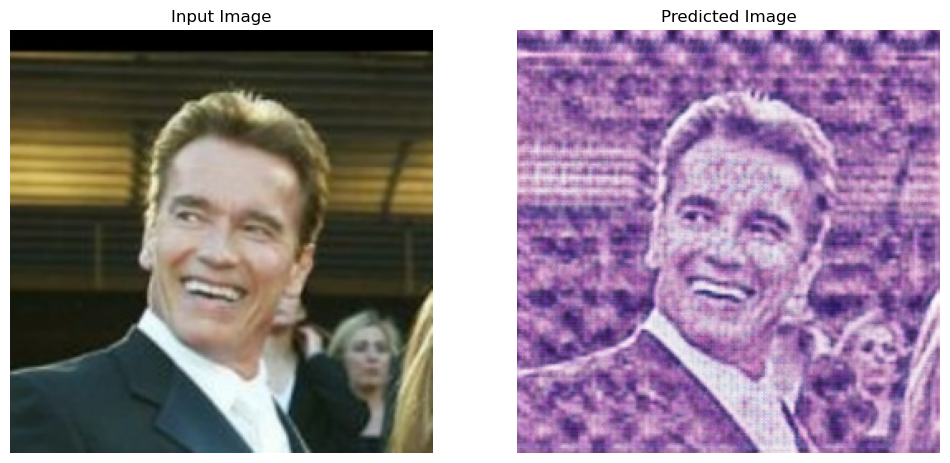

Saving checkpoint for epoch 10 at ./checkpoints/train/ckpt-2
Time taken for epoch 10 is 2742.141561985016 sec



In [227]:
for epoch in range(EPOCHS):
  start = time.time()
  f_train.shuffle(BUFFER_SIZE)
  f_minibatch = f_train.take(250)
  c_train.shuffle(BUFFER_SIZE)
  c_minibatch = c_train.take(250)

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((f_minibatch, c_train)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n += 1

  clear_output(wait=True)
  # Using a consistent image (sample_horse) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, sample_face)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

<class 'tensorflow.python.framework.ops.EagerTensor'>


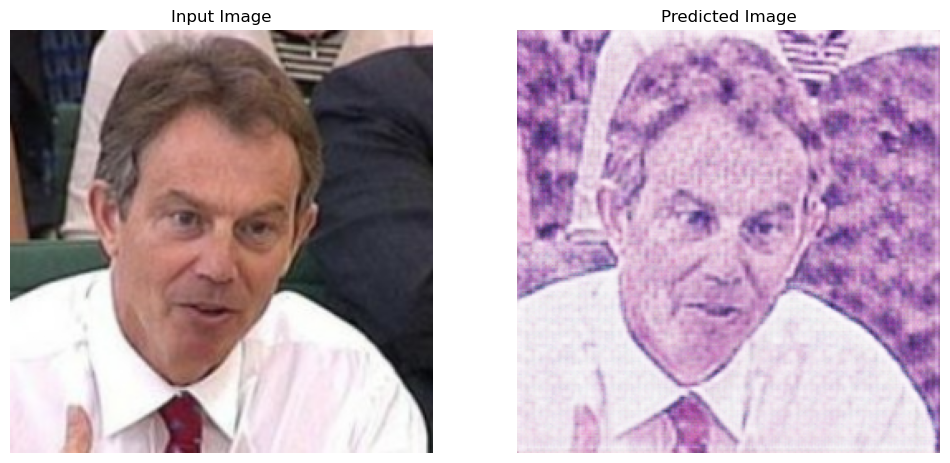

In [245]:
example_face = next(iter(f_train))
print(type(example_face))
generate_images(generator_g, example_face)

In [242]:
from PIL import Image
import cv2

In [280]:
def process(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = preprocess_image_train(img)
    return img

In [285]:
dir = "/Users/ethanreinhart/anaconda3/processing"

In [291]:
images = [dir+"/"+pic for pic in os.listdir(dir)]
pic_ds = tf.data.Dataset.from_tensor_slices(images)
print(f"Image dataset size: {len(list(pic_ds))}")

Image dataset size: 4


In [292]:
test_imgs = pic_ds.take(4)
for ele in test_imgs:
    print(ele)

tf.Tensor(b'/Users/ethanreinhart/anaconda3/processing/formal.jpg', shape=(), dtype=string)
tf.Tensor(b'/Users/ethanreinhart/anaconda3/processing/london_eye.jpg', shape=(), dtype=string)
tf.Tensor(b'/Users/ethanreinhart/anaconda3/processing/denmark.jpg', shape=(), dtype=string)
tf.Tensor(b'/Users/ethanreinhart/anaconda3/processing/selfie.jpg', shape=(), dtype=string)


In [293]:
test_imgs = test_imgs.map(process, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE)

In [296]:
print(len(test_imgs))

4


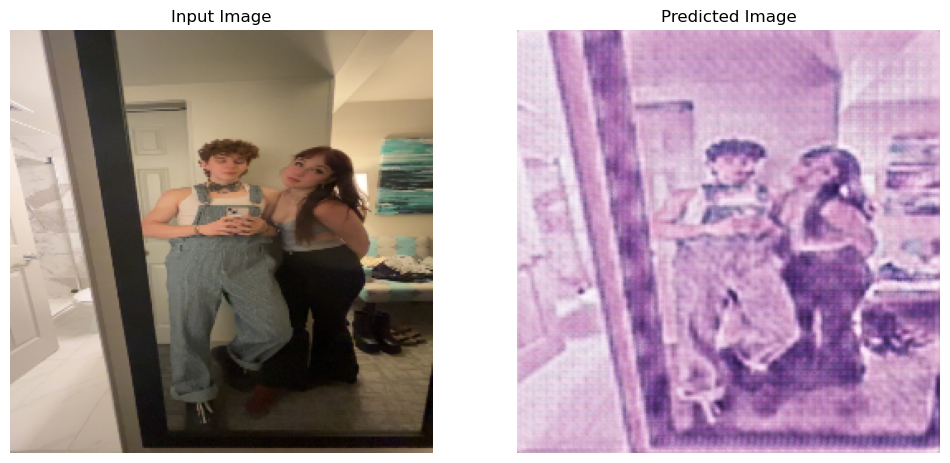

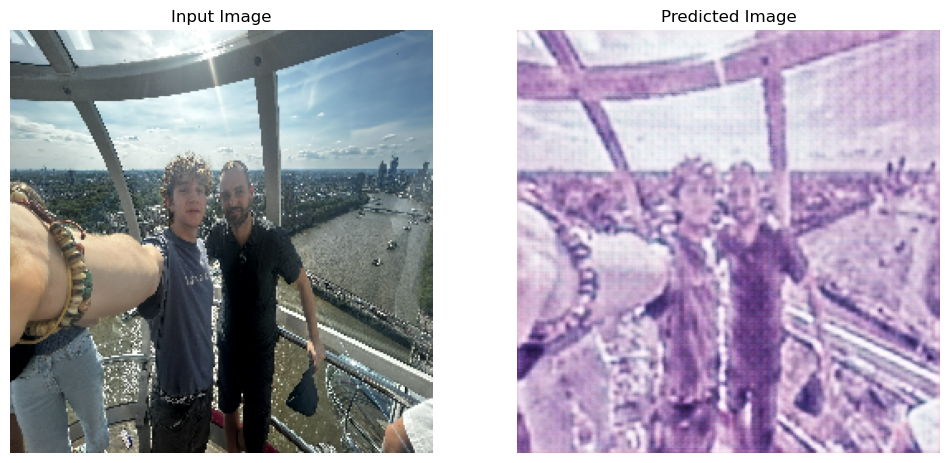

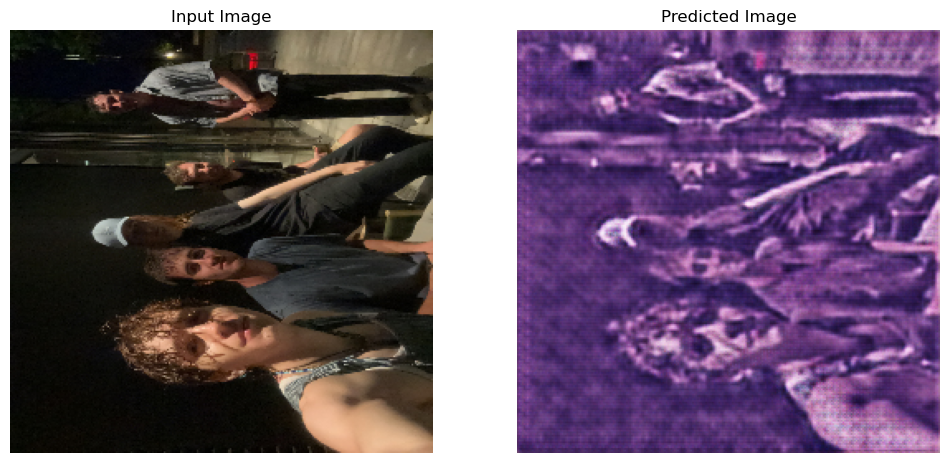

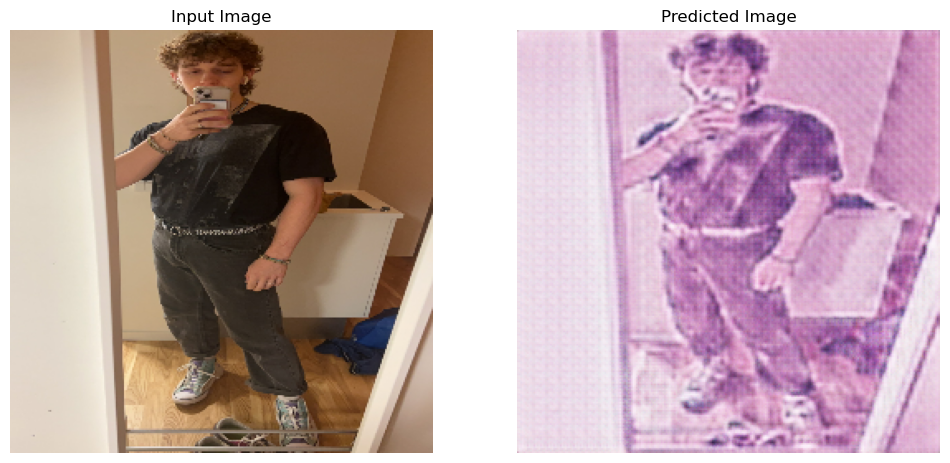

In [300]:
for img in test_imgs.take(4):
    generate_images(generator_g, img)